# Assigment 2: CAMSHIFT
## Paper
Lies das Paper "Bradski_etal_1998_camshift.pdf" im KVV (unter "Resources"). 

## Histogramm berechnen
* Implementiere eine Funktion, die ein Farbhistogramm erstellt. Übergebe entweder ein Bild und ein ROI, oder das dem ROI unterliegende Bild. 
* Hierzu ermögliche durch die Übergabe eines zweiten (bzw. dritten) Parameters die Zusammenfassung von Farbwerten in n Bins. 
* Lade das Bild "images/racecar.png" und konvertiere das Bild in den HSV-Farbraum. Plotte den Hue-Kanal. (**RESULT**)

4.0


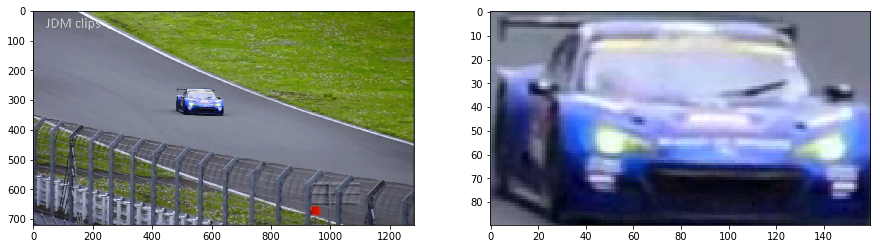

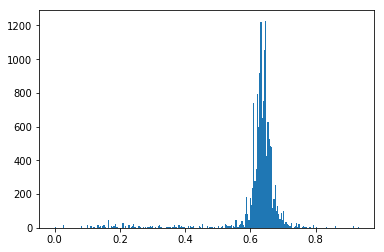

In [175]:
# dieser Code wurde als Musterlösung von Tobias Schülke zur Verfügung gestellt und von Tim renoviert

%matplotlib inline 
from skimage import io,color
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
import warnings; warnings.simplefilter('ignore')

IMAGES_PER_ROW = 4

# MIN_SATURATION_CAR = 0.2
MIN_SATURATION_CAR = 0.3
MIN_VALUE_CAR = 0.5
MIN_SATURATION_TACO = 0.8
MIN_VALUE_TACO = 0.2

ROI_FRAME_MARGIN_CAR = 60
ROI_FRAME_MARGIN_TACO = 20

image = io.imread('images/racecar.png')
imageCar = image[260:350, 480:640]

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
# ...

ax1.imshow(image)
ax2.imshow(imageCar)

# ...

imageCarHSV = color.rgb2hsv(imageCar)

def createColorHistogram(img, binCount = 256, out = plt):
    colors = []
    for y in range (0, img.shape[1]):
        for x in range (0, img.shape[0]):
            colors.append(img[x,y,0])
    return out.hist(colors, binCount)[0]


plt.figure(2)
x = createColorHistogram(imageCarHSV)
print(x[255])

* stelle das Histogramm über dem Hue-Kanal für das gesamte Bild und für den Ausschnitt (x,y) = (480, 260) bis (640, 350) dar. Variiere auch mal testweise die Zahl der Bins(**RESULT**)


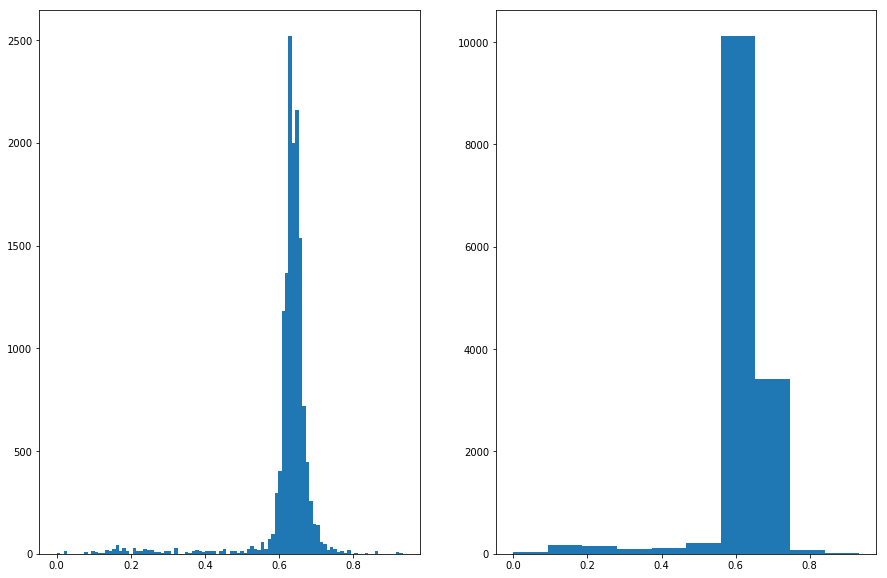

In [176]:
fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
    
histCar100 = createColorHistogram(imageCarHSV, 100, ax1)
histCar10 = createColorHistogram(imageCarHSV, 10, ax2)


## Wahrscheinlichkeitsverteilung
* implementiere die Methode aus der Vorlesung, die Dir - gegeben ein Hue-Histogramm - die Objekt-Wahrscheinlichkeitsverteilung für ein neues Bild berechnet. 
* erzeuge das Histogramm des Autos aus dem Bild "racecar.png" und wende die neue Funktion auf das letzte frame des Videos (images/racecar/151.jpg) an (**RESULT**)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

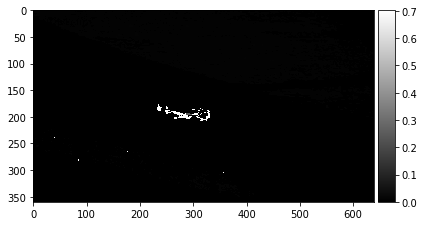

In [177]:
# Tip: in der Nacht sind alle Katzen grau ;)

def createProbDistribution(image, objectHist, nbins, minSaturation, minValue):
    histTotal = np.sum(objectHist)
    probs = np.zeros_like(image[:, :, 0], dtype=np.float32)
    
    maxSaturation = 0.97
    maxValue = 0.97
    
    for y in range (0, image.shape[1]):
        for x in range (0, image.shape[0]):
            
            if image[x, y, 1] < minSaturation or image[x, y, 2] < minValue:
                continue
            
            if image[x, y, 1] > maxSaturation or image[x, y, 2] > maxValue:
                continue
            
            objectHistIndex = int(image[x, y, 0] * nbins)
            #if objectHistIndex > nbins-1:
            #    objectHistIndex = nbins-1
                
            amount = objectHist[objectHistIndex]
            probs[x,y] = amount/histTotal
            
    return probs

binCount = 10
lastFrame = io.imread('images/racecar/020.jpeg')
frameHsv = color.rgb2hsv(lastFrame)

histogramCar = createColorHistogram(imageCarHSV, binCount, ax1)
probDistr = createProbDistribution(frameHsv, histogramCar, binCount, MIN_SATURATION_CAR, MIN_VALUE_CAR)
io.imshow(probDistr, cmap='gray')

probDistr[0:10, 0]

### ROI auf Bild anzeigen


In [227]:
def drawROI(image, x, y, width, height, out = plt):
    currentAxis = plt.gca()
    currentAxis.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False,
            edgecolor="yellow"
        )
    )
    
    out.imshow(image)


def getM00(probDistribution):
    return np.sum(probDistribution)


# def getWindowPos(probDistribution, m00):
#     height, width = probDistribution.shape
#     xPos = 0
#     yPos = 0
#     
#     for x in range (0, width):
#         for y in range (0, height):
#             prob = probDistribution[y,x]
#             
#             xPos += x * prob
#             yPos += y * prob
#             
#     return int(round(xPos / m00)), int(round(yPos / m00))


# drawROI(lastFrame, x, y, 160, 90)
# showRoiFrame(image, 480, 260, 160, 90)

##  Exercise 1.2 - Mean Shift
* Implementiere die Verschiebung und des ROI wie in der Vorlesung beschrieben. Teste den Algorithmus auf den Bildfolgen "images/racecar/*.jpg" oder "images/taco/*.jpg". Wähle das Tracking-Fenster geeignet (zur Reduktion der Dateigröße habe ich die Bilder um Faktor 2 verkleinert, d.h. die ROI von oben muss entsprechend angepasst werden). 
* Zeichne als Ausgabe die Trajektorie (die Bewegungsspur) der Objekte, wie durch CAMSHIFT zurückgegeben. (**RESULT**)

M00: 415.7897499860498
-69


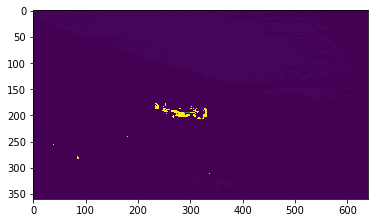

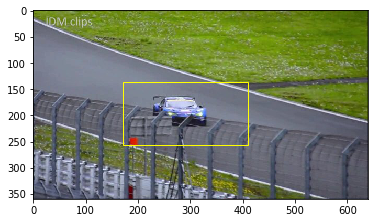

In [229]:
from skimage.filters import gaussian

x = 310

# M_SIZE_X = 160
# M_SIZE_Y = 80
# M_X = 320
# M_Y = 200# 

M_SIZE_X = 240
M_SIZE_Y = 120
M_X = 240
M_Y = 160

def getMeanWindowPos(probDistribution, mX, mY, mWidth, mHeight):
    height, width = probDistribution.shape

    winX1 = mX + mWidth if mX + mWidth < width else width-1
    winY1 = mY + mHeight if mY + mHeight < height else height-1
    
    cropped = probDistribution[mY:winY1, mX:winX1]
    smoothed = gaussian(cropped)
    m00 = getM00(smoothed) + 0.0000001
    print("M00: {}".format(m00))
    
    height, width = smoothed.shape
    xPos = 0
    yPos = 0
    
    for x in range (0, width):
        for y in range (0, height):
            prob = smoothed[y,x]
            xPos += x * prob
            yPos += y * prob
            
    return int(round(xPos / m00) - (mWidth/2)), int(round(yPos / m00) - (mHeight/2))


def meanShift(probDistr, px, py, M_SIZE_X, M_SIZE_Y):
    
    while True:
        wx,wy = getMeanWindowPos(probDistr, px, py, M_SIZE_X, M_SIZE_Y)
        px = px + wx
        py = py + wy
        print(wx)
        if wx < 2 and wy < 2:
            return px,py

def get_file_name(i):
    if i < 10:
        return "images/racecar/00" + str(i) + ".jpeg"
    if i < 100:
        return "images/racecar/0" + str(i) + ".jpeg"
    return "images/racecar/" + str(i) + ".jpeg"

M00: 415.7897499860498
-69


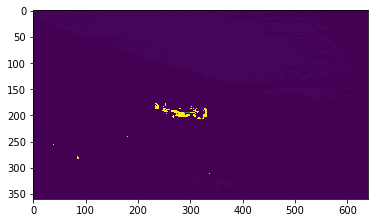

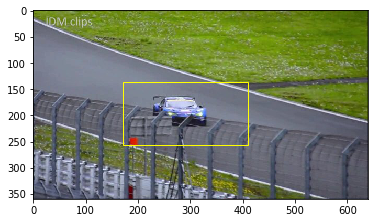

In [230]:

for i in range(0 ,150, 1):
    print(i)
    tmp_image = io.imread(get_file_name(i))
    tmp_image_hsv = color.rgb2hsv(tmp_image)
    
    
    
    
    

plt.figure(1)
plt.imshow(probDistr)

px, py = meanShift(probDistr, M_X, M_Y, M_SIZE_X, M_SIZE_Y)

plt.figure(2)
drawROI(lastFrame, px, py, M_SIZE_X, M_SIZE_Y)

##  Exercise 1.2 - CAMSHIFT
* erweitere Deinen Algorithmus um die Anpassung der Größe des ROI und das Finden der Objektorientierung
* führe den Algorithmus wieder auf eine der Bildfolgen aus und zeichne eine Ellipse auf das Bild, die die gefundenen Parameter repräsentiert (**RESULT**)